# MLP With Backpropagation For Non-Linear Data (XOR)

This post consists of:
0. Generating Synthetic Data
1. Network Structure
2. Preparing Data
    1. Convert Data to Numpy Array
    2. Create Labels
    3. Shuffle Data
    4. Split Into Train and Test
3. Build Perceptron
4. Training and Evaluation

## 0 Generating Synthetic Data
In this section we just generate 200 randomly sampled data which are **linearly** separable.

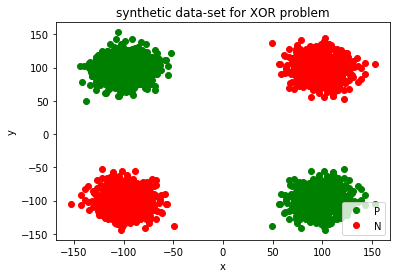

In [2]:
import numpy as np
######################
# Create random data
#####################
Positive = np.random.normal(100,15,1000)
Negative = np.random.normal(-100,15,1000)
PN=[(x,y) for x,y in zip(Positive,Negative)]
NP=[(x,y) for x,y in zip(Negative,Positive)]
PP=[(x,y) for x,y in zip(Positive,-1*(Negative))]
NN=[(x,y) for x,y in zip(-1*(Positive),1*(Negative))]
N_class = PN + NP
P_class = PP + NN

########################
# Data Visualization
########################
import matplotlib.pyplot as plt
plt.plot([x for x,y in N_class], [y for x,y in N_class], 'go', label='P')
plt.plot([x for x,y in P_class], [y for x,y in P_class], 'ro', label='N')

plt.title('synthetic data-set for XOR problem')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')

plt.show()

## 1 Network Structure
1. XOR problem is not linear so a single perceptron cannot separate data into desired classes but two perceptron can do this. Each perceptron handle a line and we know we can separate the classes using two straight lines. So we need another perceptron at the end to handle the combination of the outputs of two prior perceptrons. So we need 3 perceptron, 2 at first layer and one at the end to handle mapping to classes.
2. The number of features here are 2 so the I have considered 3 input for perceptron which weight of shape (2, 1) and (1,1) for bias too.
3. I have used backpropagation to optimize the weights of the perceptron.
4. Other parameters and the explanation of the how the model works has been expained through the following sections.

## 2 Preparing Data
In this step we take care of data using following steps:
1. Convert data to numpy array
2. Create labels
3. Shuffle data
4. Split data into train and test

### 2.A Convert Data to Numpy Array
As I am going to use numpy matrix operations, I need to convert all of our data to numpy arrays.

In [96]:
data = []
size = 4000
data.extend(PN)
data.extend(NP)
data.extend(PP)
data.extend(NN)
x = np.zeros((size, 2))
for idx, s in enumerate(data):
    x[idx, 0] = s[0]
    x[idx, 1] = s[1]

### 2.B Create Labels
Perceptron algorithm is a supervised learning task, so the data needs labels and I have assigned:
1. 0 for Red
2. 1 for Green

Note any combination is possible.

In [97]:
y = np.ones((size, 1))
y[size//2:,] = 0

### 2.C Shuffle Data
I have shuffled data because initial data was in order. In other words, first 2000 data had same label and latter half had same label so the network may memorize this order.

In [98]:
perm = np.random.permutation(size)
x = x[perm]
y = y[perm]

## 2.D Split Into Train and Test
For validation purposes, I splitted data into train and test set to have more reliable accuracy.

In [99]:
train_test_ratio = 0.9
x_train = x[0:int(train_test_ratio*size)]
y_train = y[0:int(train_test_ratio*size)]
x_test = x[int(train_test_ratio*size):]
y_test = y[int(train_test_ratio*size):]

## 3 Build Neural Network
1. Initializing weights randomly using normal distribution
    1. This Step is very important and till now between different ways of weight initialization like Quasi random etc, normal random has had better results. I have also scaled down around 0.01 as it has been used widely in practice.
    2. Initializing weights using any number is possible but it would be much more faster if we choose small values without zero weights because zero weights just stop learning!
2. Activation function
    1. This functions return the defined function's value regarding current weights and input values to the functions.
    2. I have defined two most known functions, `sigmoid` and `tanh`.
    3. Again, any sequence of activation functions is possible but it is convention to use `tanh` in hidden layers and `sigmoid` at the end of network, so I used same convetion.
3. Feed Foward
    1. Feedforward just multiplies input data and weights and pass it to activation function.
    2. Step 1 will be applied to all layers which means first, input and hidden layers' weights are engaged, then output of hidden layers and weights of hidden layers to final neuron.
    2. The result is network's prediction regarding given input
4. Backpropagation
    1. The main difference between a single perceptron and MLP is this step. Backpropagation enable us to transfer error from last layer(our prediction) to any of prior layers and that is why we can use multilayer perceptron.
    2. The intuitive explanation will be as follow:
        1. First we obtain difference between prediction and true labels
        2. Then we calculate how much hidden layer's activation contributed to this error.
        3. After that we do same definiton (actually obtained through taking derivatives) for other layers till to input weights.
5. Update
    1. In this step we update weights using gradient descent rule which is as follow: `w = w - alpha*dw` where `w: weights`, `alpha: learning_rate` and `dw: derivative of w`.
    2. This rule also applies on `bias` variable too. `bias` can be considered as a single weight with input value `1` permanently, so I omited separate explanation for it.
6. Cost
    1. I omit explanation of the cost function as it was not part of assignment and I have just implemented it to make sure my implementation is correct and gradients are working properly.
    2. I used cross-entopy loss
6. Training
    1. Feedforward step has been explained in the previous sections.
    2. Backpropagation step has been explained in the previous sections.
    3. Updating parameters step has been explained in the previous sections.
    4. Reporting cost is optional.
5. Testing
    1. Testing step is only forward pass after training weights
    2. I have not used thresholding in this step to enable us have a look at the values' intensities.
6. Score
    1. Calculating score is just dividing number of correct predictions by number of tests.
    2. As the activation function in the last layer is `sigmoid`, we need a `threshold system` to convert `(0, 1)` output of `sigmoid` to `{0, 1}` and `0.5` will do this for us.

In [126]:
class MLP:
    def __init__(self, num_features, hidden_size = 2, learning_rate = 0.001):
        """
        Builds a MLP
        
        :param num_features: Number of input features
        :param learning_rate: eta or learning rate as a coefficient for weight updating
        :param hidden_size: Number of neurons in hidden layer
        :return: A object
        """
        
        self.w1 = np.random.randn(hidden_size, num_features) * 0.01  # weights of input to hidden layer
        self.b1 = np.ones((hidden_size, 1))  # bias of hidden layer
        self.w2 = np.random.randn(1, hidden_size) * 0.01  # weights of hidden layer to output
        self.b2 = np.ones((1, 1))  # bias of output layer
        
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.num_features = num_features
    
    def _sigmoid(self, x):
        """
        Applies sigmoid function on data
        
        :param x: numpy ndarray
        :return: numpy ndarray
        """
        return 1 / (1 + np.exp(-x))
    
    def _tanh(self, x):
        """
        Applies Tan Hyperbolic function on data
        
        :param x: numpy ndarray
        :return: numpy ndarray
        """
        return np.tanh(x)
            
    def forward(self, x):
        """
        Applies feed forward logic regarding predefined activation function
        
        :param x: numpy ndarray of input data
        :return: a tuple of (input of activation function of hidden layer,
                            output of activation function of hidden layer,
                            input of activation function of output layer,
                            output of activation function of output layer)
        
        """
        z1 = np.dot(self.w1, x) + self.b1
        a1 = self._tanh(z1)
        z2 = np.dot(self.w2, a1) + self.b2
        a2 = self._sigmoid(z2)
        return z1, a1, z2, a2
        
    def backpropagation(self, x, y, z1, a1, z2, a2):
        """
        Applies backpropagation algorithm on network
        
        :param x: numpy ndarray of input data
        :param y: numpy ndarray of input labels
        :param z1: input of activation function of hidden layer
        :param a1: output of activation function of hidden layer
        :param z2: input of activation function of output layer
        :param a2: output of activation function of output layer
        :return: A tuple of (delta_w1, delta_b1, delta_w2, delta_b2)
        """
        m = x.shape[1]
        dz2 = a2 - y
        dw2 = np.dot(dz2, a1.T) / m
        db2 = np.sum(dz2, axis=1, keepdims=True) / m
        dz1 = np.multiply(np.dot(self.w2.T, dz2), (1-np.power(a1, 2)))
        dw1 = np.dot(dz1, x.T) / m
        db1 = np.sum(dz1, axis=1, keepdims=True) / m
        return dw1, db1, dw2, db2
    
    def update(self, dw1, db1, dw2, db2):
        """
        Updates parameters using optained gradient changes.
        
        :param dw1: Amount of change in w1
        :param db1: Amount of change in b1
        :param dw2: Amount of change in w2
        :param db2: Amount of change in b2
        :return: None
        """
        self.w1 = self.w1 - self.learning_rate*dw1
        self.b1 = self.b1 - self.learning_rate*db1
        self.w2 = self.w2 - self.learning_rate*dw2
        self.b2 = self.b2 - self.learning_rate*db2
        
    def compute_cost(self, a2, y):
        """
        Calculates cross-entropy loss
        
        :param a2: output of final layer
        :param y: true labels of input data
        
        :return: a float value (less better!)
        """
        logprobs = np.multiply(y, np.log(a2))+ np.multiply((1-y), (np.log(1-a2)))
        cost = -np.sum(logprobs)/y.shape[1]
        cost = np.squeeze(cost)
        return cost
    
    def train(self, x, y, epochs, print_cost=True):
        """
        Applies training procedure
        
        :param x: numpy ndarray of input features
        :param y: numpy ndarray of input labels
        :param epochs: Number of epochs to be trained
        :print_cost: Whether or not print cost value (debugging purposes) every 1000 epochs
        :return: None
        """
        for e in range(epochs):
            z1, a1, z2, a2 = self.forward(x)
            cost = self.compute_cost(a2, y)
            dw1, db1, dw2, db2 = self.backpropagation(x, y, z1, a1, z2, a2)
            self.update(dw1, db1, dw2, db2)
            if print_cost and e % 1000 == 0:
                print ("Cost after iteration %i: %f" %(e, cost))
    
    def test(self, x):
        """
        Tests network using trained weights obtained from `train` method.
        Note: Mapping is not happening here, if you want to map, use 0.5 as threshold for sigmoid
        
        :param x: numpy ndarray of input features
        :return: numpy ndarray of predictions
        """
        _, _, _, preds = self.forward(x)
        return preds
    
    def score(self, x, y):
        return np.count_nonzero((self.test(x)>=0.5)*1 == y) *100/ x.shape[1]

## 4 Training and Evaluation

In [136]:
x_train_mlp = x_train.transpose()
y_train_mlp = y_train.transpose()
mlp = MLP(num_features=2, hidden_size=2)
mlp.train(x_train_mlp, y_train_mlp, epochs=15000)
pred = mlp.test(x_test.T)
mlp.score(x_test.T, y_test.T)

Cost after iteration 0: 0.811356
Cost after iteration 1000: 0.661713
Cost after iteration 2000: 0.561364
Cost after iteration 3000: 0.493442
Cost after iteration 4000: 0.444247
Cost after iteration 5000: 0.406091
Cost after iteration 6000: 0.374814
Cost after iteration 7000: 0.348163
Cost after iteration 8000: 0.324874
Cost after iteration 9000: 0.304196
Cost after iteration 10000: 0.285649
Cost after iteration 11000: 0.268904
Cost after iteration 12000: 0.253713
Cost after iteration 13000: 0.239883
Cost after iteration 14000: 0.227255


100.0

### Note
1. Our dataset enabled us to have 100 accuracy using only two neurons.
2. If we add about %10 noise to data, our accuracy will be approximately around %80 because we have only two lines with overlapping dat.
3. The solution is using 4 neurons in hidden layer to enable us having a almost seprable data.
4. The last note is that 2-neuron model takes much more time (epochs) to train rather than 3-neuron or 4-neuron model as I have made sure this result using Google Tensorflow's Playground.